In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

In [2]:
all_cn_data_fp = "/Users/massoudmaher/data/sc_1935_1936_1937_cn_data_qc.csv"
all_cn_data = pd.read_csv(all_cn_data_fp)
all_cn_data = all_cn_data.iloc[:,1:]
###
all_cn_data = all_cn_data[all_cn_data["chr"]=="X"]

In [3]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [4]:
subsample = utils.get_cn_data_submixture(all_cn_data, total_ncells, hmmcopy_tickets, sample_ids, proportions=proportions)

mixed_cn_data = subsample["mixed_cn_data"]
mixed_cn_data["origin_id_int"] = mixed_cn_data["origin_id"].factorize()[0]
cell_counts = subsample["cell_counts"]

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jira_cn_data[origin_field_name] = hmmcopy_tickets[i]


In [5]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change, debug=True,
                              clustering_id="copy")
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

cell_state_var: 
                    cell_id  state  copy_var
0    SA1090-A96213A-R20-C17      0  0.004509
1    SA1090-A96213A-R20-C17      1  0.040301
2    SA1090-A96213A-R20-C17      2  0.002300
3    SA1090-A96213A-R22-C30      2  0.085903
4    SA1090-A96213A-R22-C30      4  0.000105
5    SA1090-A96213A-R22-C33      1  0.057182
6    SA1090-A96213A-R22-C39      1  0.023795
7    SA1090-A96213A-R22-C39      2  0.028223
8    SA1090-A96213A-R22-C46      1  0.030764
9    SA1090-A96213A-R22-C46      2  0.008036
10   SA1090-A96213A-R22-C49      0  0.007315
11   SA1090-A96213A-R22-C49      1  0.035819
12   SA1090-A96213A-R24-C33      1  0.019905
13   SA1090-A96213A-R24-C33      2  0.182184
14   SA1090-A96213A-R24-C64      1  0.032959
15   SA1090-A96213A-R24-C66      1  0.016764
16   SA1090-A96213A-R24-C66      2  0.031624
17   SA1090-A96213A-R25-C21      1  0.019117
18   SA1090-A96213A-R25-C21      2  0.003504
19   SA1090-A96213A-R25-C44      1  0.050162
20   SA1090-A96213A-R26-C62      1  0.

In [31]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(lbhc_plot_data[:,2]) # Log because the highest link is way higher

naive_linkage = sch.linkage(measurement[], method=naive_method, metric=naive_metric)
##
naive_linkage[:,2] = naive_linkage[:,2] + 1
lnaive_linkage = naive_linkage.copy()
lnaive_linkage[:,2] = np.log(lnaive_linkage[:,2])

ValueError: The condensed distance matrix must contain only finite values.

In [39]:
def apply_fn(row):
    if row["transform"] == "log":
        #df = lbhc_plot_data
        df = bhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

def apply_fn(row):
    if row["transform"] == "log":
        df = lnaive_linkage
    else:
        df = naive_linkage
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["naive_fcluster"] = params.apply(apply_fn, axis=1)
params["naive_num_clusters"] = params["naive_fcluster"].apply(lambda x: len(set(x)))

params.head()

,transform,criterion,threshold,bhc_fcluster,bhc_num_clusters,naive_fcluster,naive_num_clusters
0,log,inconsistent,0.025,"[1, 6, 3, 8, 10, 14, 16, 15, 9, 1, 21, 7, 5, 1...",52,"[1, 3, 3, 3, 2, 3, 3, 1, 1, 4, 11, 1, 1, 1, 8,...",18
1,log,inconsistent,0.075,"[1, 6, 3, 8, 10, 14, 16, 15, 9, 1, 21, 7, 5, 1...",52,"[1, 3, 3, 3, 2, 3, 3, 1, 1, 4, 11, 1, 1, 1, 8,...",18
2,log,inconsistent,0.125,"[1, 6, 3, 8, 10, 14, 16, 15, 9, 1, 21, 7, 5, 1...",52,"[1, 3, 3, 3, 2, 3, 3, 1, 1, 4, 11, 1, 1, 1, 8,...",18
3,log,inconsistent,0.175,"[1, 6, 3, 8, 10, 14, 16, 15, 9, 1, 21, 7, 5, 1...",52,"[1, 3, 3, 3, 2, 3, 3, 1, 1, 4, 11, 1, 1, 1, 8,...",18
4,log,inconsistent,0.225,"[1, 6, 3, 8, 10, 14, 16, 15, 9, 1, 21, 7, 5, 1...",52,"[1, 3, 3, 3, 2, 3, 3, 1, 1, 4, 11, 1, 1, 1, 8,...",18


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


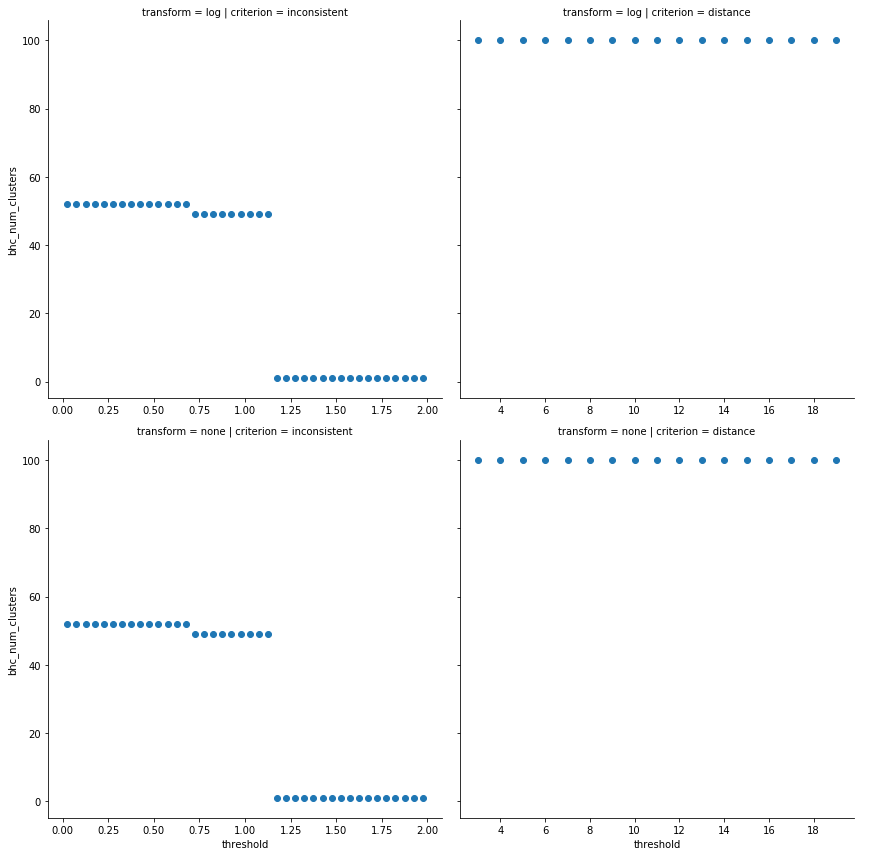

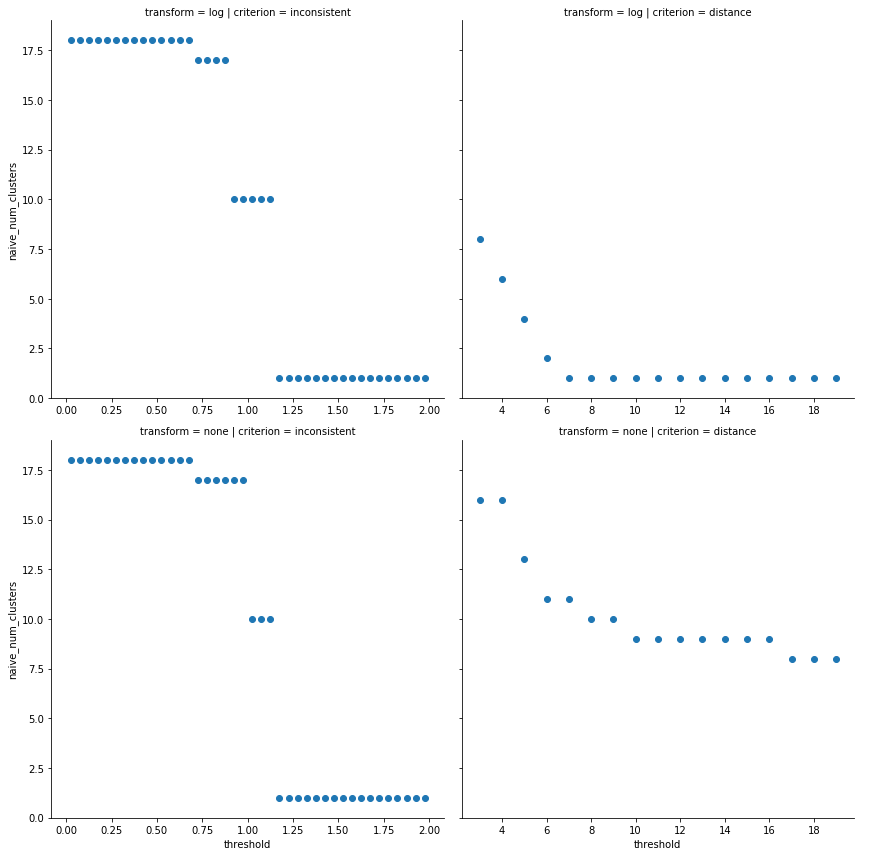

In [40]:
g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "naive_num_clusters")

## Rightmost bar represents where sample originally came frome

homogeneity: 1.0000000000000002, completeness: 0.23645162531850888, v-measure: 0.38246805694092423


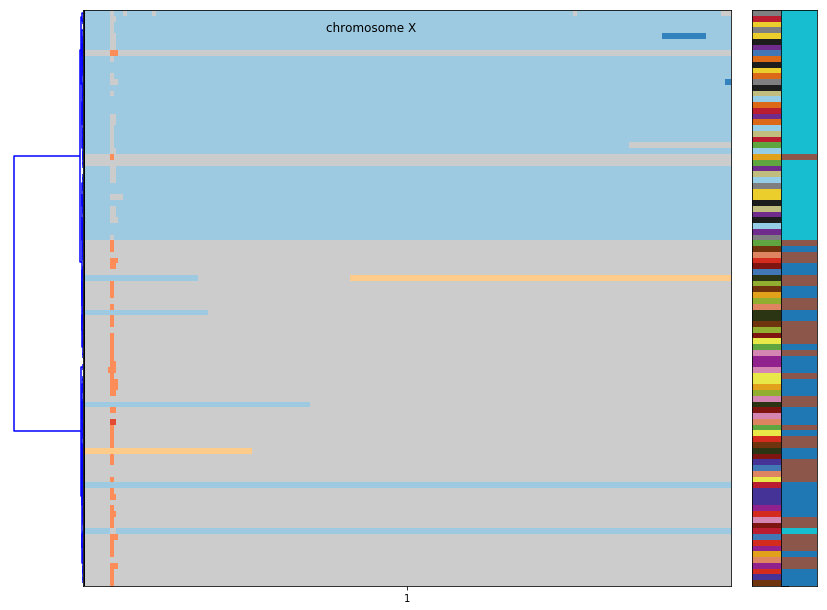

In [41]:
cmixed_cn_data = mixed_cn_data.copy()
clustering = sch.fcluster(bhc_plot_data, 10, criterion="distance")
cmixed_cn_data = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=bhc_plot_data, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(cmixed_cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [ ]:
naive_clusters = sch.fcluster(lnaive_linkage, 6, criterion="distance")
assert len(set(naive_clusters)) > 1
nmixed_cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, mixed_cn_data, 
                                         cluster_field_name="naive_cluster_id")
fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, nmixed_cn_data, "state", cluster_field_name="naive_cluster_id",
    linkage=lnaive_linkage, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(nmixed_cn_data, obs_name="naive_cluster_id")
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["naive_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [ ]:
umap_params = utils.expand_grid({"n_neighbors": np.arange(3,18,step=1)})
def apply_fn(row):
    return cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=row["n_neighbors"])

umap_params["umap_clusters"] = umap_params.apply(apply_fn, axis=1)
umap_params["umap_num_clusters"] = umap_params["umap_clusters"].apply(lambda x: len(set(x["cluster_id"])))

sns.scatterplot(data=umap_params, x="n_neighbors", y="umap_num_clusters")

umap_df = cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=15)
umixed_cn_data = mixed_cn_data.merge(umap_df, how="inner")

fig = plt.figure(figsize=(4, 4))
cncluster.plot_umap_clusters(plt.gca(), umap_df)

fig = plt.figure(figsize=(4, 4))
sns.barplot(x='cluster_id', y='count', data=umap_df.groupby('cluster_id').size().rename('count').reset_index())


fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, umixed_cn_data, "state", cluster_field_name="cluster_id",
    linkage=None, origin_field_name="origin_id_int")
fig.suptitle("chromosome X")

clabels = get_mixture_labels(umixed_cn_data, obs_name="cluster_id")
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")
#def umap_hdbscan_cluster(
#        cn,
#        n_components=2,
#        n_neighbors=15,
#        min_dist=0.1,
#):

In [14]:
bhc_linkage.to_csv("/Users/massoudmaher/Downloads/linkage.csv")

In [32]:
measurement

array([[       nan, 0.75660721,        nan, ..., 1.17535172, 0.81526686,
               nan],
       [       nan, 0.88828107,        nan, ..., 1.06299639, 0.77706014,
               nan],
       [       nan, 0.49157069,        nan, ..., 1.07157491, 0.87299665,
               nan],
       ...,
       [       nan, 1.97982397,        nan, ..., 2.14280342, 1.86783936,
               nan],
       [       nan, 1.74734084,        nan, ..., 1.97765099, 1.34041564,
               nan],
       [       nan, 1.6674791 ,        nan, ..., 2.14757623, 1.82898481,
               nan]])

In [38]:
a = np.array([[1,2,3], [4,5,np.nan], [7,8,9]])
print(a)
a[:,~np.isnan(a).any(axis=0)]

[[ 1.  2.  3.]
 [ 4.  5. nan]
 [ 7.  8.  9.]]


array([[1., 2.],
       [4., 5.],
       [7., 8.]])

In [47]:
subsample["mixed_cn_data"].to_csv("~/data/sc1935to37_spike_in.csv")

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int
11982,X,1,500000,355,-1.000000,NaN,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11983,X,500001,1000000,551,0.458294,1.575578,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11984,X,1000001,1500000,420,-1.000000,NaN,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11985,X,1500001,2000000,627,0.481712,1.834921,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11986,X,2000001,2500000,687,-1.000000,NaN,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11987,X,2500001,3000000,806,0.448584,2.292402,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11988,X,3000001,3500000,899,0.414510,2.557338,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11989,X,3500001,4000000,653,0.437568,1.851367,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11990,X,4000001,4500000,817,0.379672,2.397664,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
11991,X,4500001,5000000,749,0.373268,2.218702,2,SA922-A90554B-R33-C19,SA922,A90554B,SC-1935,0
